In [20]:
import numpy as np
import csv
import matplotlib.pyplot as plt

In [21]:
box_center = [0.565, 0.0, 0.0825-0.025]
box_dimensions = [0.16, 0.16, 0.165]
fixed_sphere_diameter = 0.16

In [22]:
def get_min_max_box(box_center,box_dimension):
    half_dims = box_dimension/2
    box_min = box_center - half_dims
    box_max = box_center + half_dims
    return box_min, box_max
def sphere_intersects_box(sphere_center,sphere_radius, box_min,box_max):
    
    # closest point on a box to a sphere center
    closest_point = np.maximum(box_min,np.minimum(sphere_center,box_max))
    
    
    # squared distance between the sphere center and this closest point
    distance = np.sum((sphere_center-closest_point)**2)
    
    return distance <= (sphere_radius**2)
    

In [23]:
def read_csv_file(filepath):
    sphere_data = []
    with open(filepath, mode='r', newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row_number, row in enumerate(reader,start=1):
            point_number = row.get('point_number', f"Row_{row_number}")
            x = round(float(row['x']),3)
            y = round(float(row['y']),3)
            z = round(float(row['z']),3)
            sphere_data.append({'point_number': point_number, 'coords': [x, y, z]})
            
    return sphere_data
            
            

In [24]:
def analyze_sphere_intersections(box_center_coords, box_dimensions_vals, sphere_diameter, csv_file_path):
        box_center_np = np.array(box_center_coords, dtype=float)
        box_dimensions_np = np.array(box_dimensions_vals, dtype=float)
        sphere_radius = sphere_diameter / 2.0
        
        box_min, box_max = get_min_max_box(box_center_np, box_dimensions_np)
        print(f"Processing file: {csv_file_path}")
        print(f"Box Center: {box_center_coords}, Dimensions: {box_dimensions_vals}")
        print(f"Box Min: {box_min.tolist()}, Box Max: {box_max.tolist()}")
        print(f"Sphere Diameter: {sphere_diameter}, Radius: {sphere_radius}\n")
        
        all_sphere_data = read_csv_file(csv_file_path)
        if not all_sphere_data:
            print("No sphere data loaded or error in reading CSV.")
            return []
        
        results = []
        intersecting_spheres_count = 0
        for sphere_info in all_sphere_data:
            sphere_center_coords = sphere_info['coords']
            sphere_center_np = np.array(sphere_center_coords, dtype=float)
            
            intersects = sphere_intersects_box(sphere_center_np, sphere_radius, box_min, box_max)
            if intersects:
                intersecting_spheres_count += 1
            
            results.append({
                'point_number': sphere_info['point_number'],
                'coords': sphere_center_coords,
                'intersects': intersects
            })
            
        print(f"Finished processing. Found {intersecting_spheres_count} intersecting sphere(s) out of {len(all_sphere_data)} total spheres.\n")
       
        return results
            
    

In [25]:
def plot_box_and_spheres_3d(box_min, box_max, intersection_results, sphere_diameter):
    """
    Creates an interactive 3D plot of the box and spheres (showing their radius).
    Spheres are color-coded based on intersection status.

    Args:
        box_min (np.ndarray): Min coordinates of the box [min_x, min_y, min_z].
        box_max (np.ndarray): Max coordinates of the box [max_x, max_y, max_z].
        intersection_results (list): List of dictionaries from analyze_sphere_intersections.
        sphere_diameter (float): Diameter of the spheres.
    """
    fig = plt.figure(figsize=(10, 8)) 
    ax = fig.add_subplot(111, projection='3d')
    sphere_radius = sphere_diameter / 2.0

    corners = np.array([
        [box_min[0], box_min[1], box_min[2]], [box_max[0], box_min[1], box_min[2]],
        [box_max[0], box_max[1], box_min[2]], [box_min[0], box_max[1], box_min[2]],
        [box_min[0], box_min[1], box_max[2]], [box_max[0], box_min[1], box_max[2]],
        [box_max[0], box_max[1], box_max[2]], [box_min[0], box_max[1], box_max[2]],
    ])
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0), (4, 5), (5, 6), (6, 7), (7, 4),
        (0, 4), (1, 5), (2, 6), (3, 7)
    ]
    for edge in edges:
        ax.plot3D(corners[edge, 0], corners[edge, 1], corners[edge, 2], color="gray")


    u = np.linspace(0, 2 * np.pi, 20) 
    v = np.linspace(0, np.pi, 10)
    x_unit_sphere = np.outer(np.cos(u), np.sin(v))
    y_unit_sphere = np.outer(np.sin(u), np.sin(v))
    z_unit_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

    all_sphere_coords_x = []
    all_sphere_coords_y = []
    all_sphere_coords_z = []

    # Dummy plots for legend
    ax.plot([np.nan], [np.nan], [np.nan], color='red', label='Intersecting Spheres')
    ax.plot([np.nan], [np.nan], [np.nan], color='blue', label='Non-Intersecting Spheres')


    for result in intersection_results:
        center = np.array(result['coords'])
        x_s = center[0] + sphere_radius * x_unit_sphere
        y_s = center[1] + sphere_radius * y_unit_sphere
        z_s = center[2] + sphere_radius * z_unit_sphere
        
        all_sphere_coords_x.extend(x_s.flatten())
        all_sphere_coords_y.extend(y_s.flatten())
        all_sphere_coords_z.extend(z_s.flatten())

        color = 'red' if result['intersects'] else 'blue'
        alpha_val = 0.6 if result['intersects'] else 0.3
        
        ax.plot_surface(x_s, y_s, z_s, color=color, alpha=alpha_val, rstride=1, cstride=1, linewidth=0, antialiased=True)


    # Setting plot properties
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_zlabel('Z coordinate')
    
    all_x = np.concatenate(([box_min[0], box_max[0]], np.array(all_sphere_coords_x)))
    all_y = np.concatenate(([box_min[1], box_max[1]], np.array(all_sphere_coords_y)))
    all_z = np.concatenate(([box_min[2], box_max[2]], np.array(all_sphere_coords_z)))
    
    if len(all_x) > 0 and len(all_y) > 0 and len(all_z) > 0:
        ax.auto_scale_xyz(all_x, all_y, all_z)
    
    world_limits = ax.get_w_lims()
    ax.set_box_aspect((world_limits[1]-world_limits[0], world_limits[3]-world_limits[2], world_limits[5]-world_limits[4]))

    ax.legend()
    plt.show() 

In [26]:
def analysis(selected_csv_file,box_center = box_center,box_dimensions = box_dimensions,fixed_sphere_diameter = fixed_sphere_diameter):
    intersection_results = analyze_sphere_intersections(
        box_center,
        box_dimensions,
        fixed_sphere_diameter,
        selected_csv_file
    )
    
    
    if intersection_results:
        print(f"Intersection Results for '{selected_csv_file}':")
        for result in intersection_results:

            print(f"  Point {result['point_number']} at {result['coords']}: Intersects = {result['intersects']}")
    else:
        print(f"No results to display for '{selected_csv_file}'. Check for errors above.")
        
    if intersection_results:
        box_min_np, box_max_np = get_min_max_box(np.array(box_center), np.array(box_dimensions))
        
        plot_box_and_spheres_3d(
            box_min_np,
            box_max_np,
            intersection_results,
            fixed_sphere_diameter
        )
    else:
        print(f"No results to visualize for '{selected_csv_file}'. Check for errors above.")

# BOX MID PLACEMENT

In [27]:
box_center = [0.565, 0.0, 0.0825-0.025]
box_dimensions = [0.16, 0.16, 0.165]
fixed_sphere_diameter = 0.16

### EEF MID

Processing file: measurement_mid_EEF/contact_points_log1_mid.csv
Box Center: [0.565, 0.0, 0.0575], Dimensions: [0.16, 0.16, 0.165]
Box Min: [0.48499999999999993, -0.08, -0.025], Box Max: [0.6449999999999999, 0.08, 0.14]
Sphere Diameter: 0.16, Radius: 0.08

Finished processing. Found 10 intersecting sphere(s) out of 10 total spheres.

Intersection Results for 'measurement_mid_EEF/contact_points_log1_mid.csv':
  Point 1 at [0.462, -0.02, 0.157]: Intersects = True
  Point 2 at [0.455, -0.037, 0.146]: Intersects = True
  Point 3 at [0.512, 0.041, 0.157]: Intersects = True
  Point 4 at [0.514, 0.061, 0.206]: Intersects = True
  Point 5 at [0.562, -0.014, 0.153]: Intersects = True
  Point 6 at [0.555, -0.035, 0.147]: Intersects = True
  Point 7 at [0.613, 0.048, 0.158]: Intersects = True
  Point 8 at [0.611, 0.069, 0.195]: Intersects = True
  Point 9 at [0.662, -0.02, 0.158]: Intersects = True
  Point 10 at [0.656, -0.044, 0.153]: Intersects = True


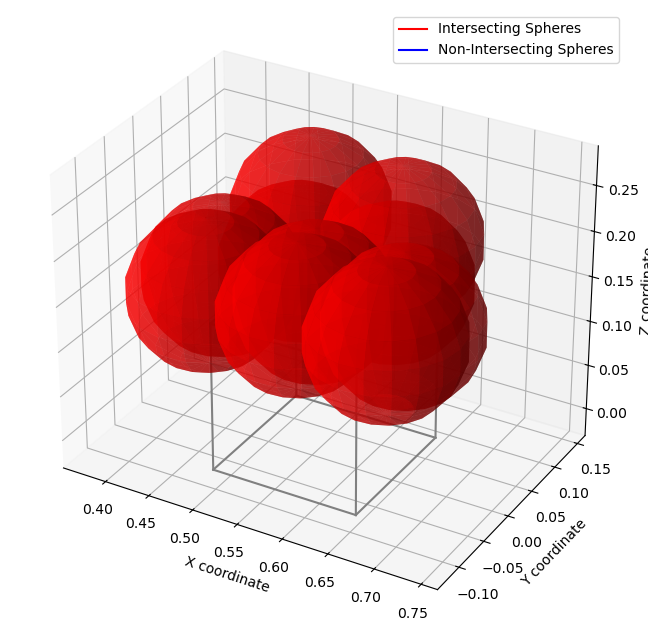

Processing file: measurement_mid_EEF/contact_points_log2_mid.csv
Box Center: [0.565, 0.0, 0.0575], Dimensions: [0.16, 0.16, 0.165]
Box Min: [0.48499999999999993, -0.08, -0.025], Box Max: [0.6449999999999999, 0.08, 0.14]
Sphere Diameter: 0.16, Radius: 0.08

Finished processing. Found 10 intersecting sphere(s) out of 10 total spheres.

Intersection Results for 'measurement_mid_EEF/contact_points_log2_mid.csv':
  Point 1 at [0.462, -0.025, 0.157]: Intersects = True
  Point 2 at [0.455, -0.038, 0.146]: Intersects = True
  Point 3 at [0.512, 0.038, 0.157]: Intersects = True
  Point 4 at [0.513, 0.062, 0.208]: Intersects = True
  Point 5 at [0.563, -0.016, 0.158]: Intersects = True
  Point 6 at [0.555, -0.036, 0.147]: Intersects = True
  Point 7 at [0.612, 0.049, 0.158]: Intersects = True
  Point 8 at [0.608, 0.07, 0.167]: Intersects = True
  Point 9 at [0.662, -0.016, 0.158]: Intersects = True
  Point 10 at [0.657, -0.037, 0.16]: Intersects = True


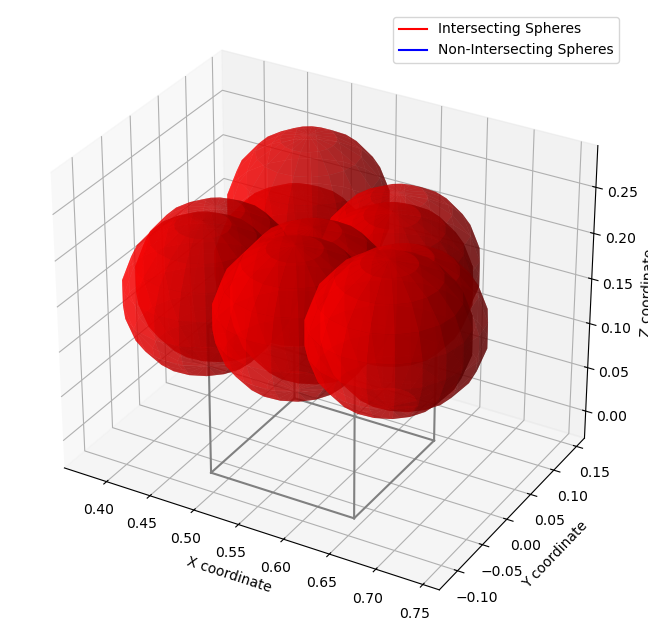

Processing file: measurement_mid_EEF/contact_points_log3_mid.csv
Box Center: [0.565, 0.0, 0.0575], Dimensions: [0.16, 0.16, 0.165]
Box Min: [0.48499999999999993, -0.08, -0.025], Box Max: [0.6449999999999999, 0.08, 0.14]
Sphere Diameter: 0.16, Radius: 0.08

Finished processing. Found 10 intersecting sphere(s) out of 10 total spheres.

Intersection Results for 'measurement_mid_EEF/contact_points_log3_mid.csv':
  Point 1 at [0.463, -0.02, 0.157]: Intersects = True
  Point 2 at [0.46, -0.033, 0.178]: Intersects = True
  Point 3 at [0.513, 0.044, 0.157]: Intersects = True
  Point 4 at [0.514, 0.064, 0.208]: Intersects = True
  Point 5 at [0.571, -0.011, 0.218]: Intersects = True
  Point 6 at [0.555, -0.027, 0.147]: Intersects = True
  Point 7 at [0.613, 0.049, 0.158]: Intersects = True
  Point 8 at [0.609, 0.066, 0.184]: Intersects = True
  Point 9 at [0.654, -0.013, 0.097]: Intersects = True
  Point 10 at [0.663, -0.04, 0.21]: Intersects = True


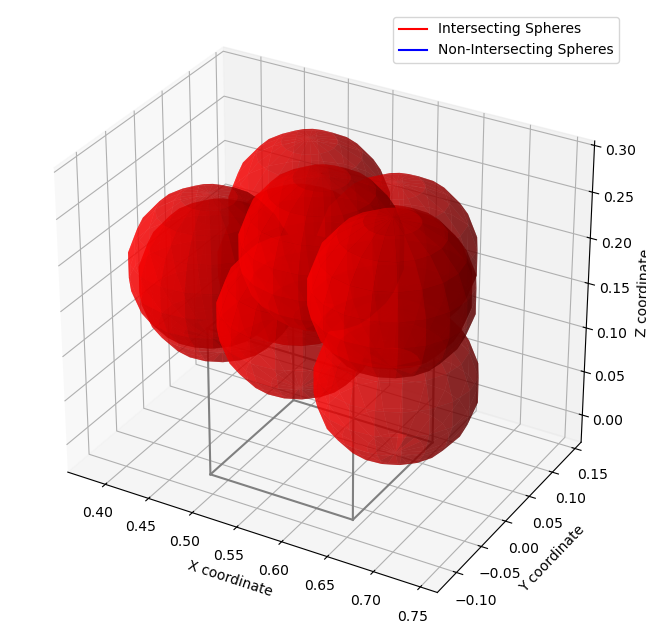

In [28]:
eef_mid_files = [
    "measurement_mid_EEF/contact_points_log1_mid.csv",
    "measurement_mid_EEF/contact_points_log2_mid.csv",
    "measurement_mid_EEF/contact_points_log3_mid.csv"
]
for selected_csv_file in eef_mid_files:
    analysis(selected_csv_file,box_center = box_center,box_dimensions = box_dimensions,fixed_sphere_diameter = fixed_sphere_diameter)

### FULL-ARM MID

Processing file: measurement_mid_fullarm/contact_points_log1_mid.csv
Box Center: [0.565, 0.0, 0.0575], Dimensions: [0.16, 0.16, 0.165]
Box Min: [0.48499999999999993, -0.08, -0.025], Box Max: [0.6449999999999999, 0.08, 0.14]
Sphere Diameter: 0.16, Radius: 0.08

Finished processing. Found 4 intersecting sphere(s) out of 4 total spheres.

Intersection Results for 'measurement_mid_fullarm/contact_points_log1_mid.csv':
  Point 1 at [0.471, -0.006, 0.152]: Intersects = True
  Point 2 at [0.459, 0.006, 0.192]: Intersects = True
  Point 3 at [0.541, -0.031, 0.153]: Intersects = True
  Point 4 at [0.428, 0.022, 0.193]: Intersects = True


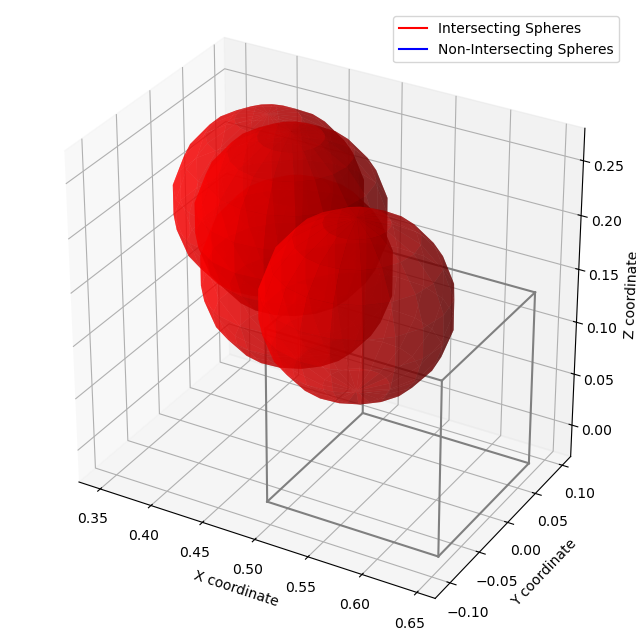

Processing file: measurement_mid_fullarm/contact_points_log2_mid.csv
Box Center: [0.565, 0.0, 0.0575], Dimensions: [0.16, 0.16, 0.165]
Box Min: [0.48499999999999993, -0.08, -0.025], Box Max: [0.6449999999999999, 0.08, 0.14]
Sphere Diameter: 0.16, Radius: 0.08

Finished processing. Found 4 intersecting sphere(s) out of 4 total spheres.

Intersection Results for 'measurement_mid_fullarm/contact_points_log2_mid.csv':
  Point 1 at [0.485, -0.002, 0.153]: Intersects = True
  Point 2 at [0.452, -0.011, 0.193]: Intersects = True
  Point 3 at [0.423, 0.01, 0.153]: Intersects = True
  Point 4 at [0.587, -0.026, 0.194]: Intersects = True


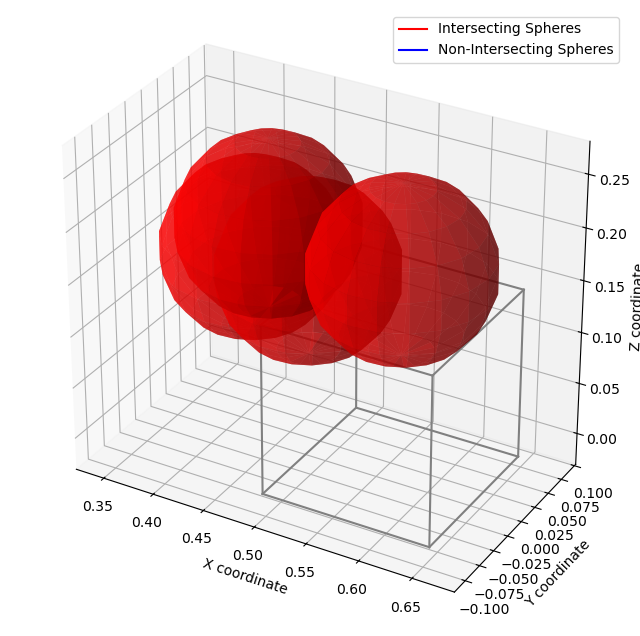

Processing file: measurement_mid_fullarm/contact_points_log3_mid.csv
Box Center: [0.565, 0.0, 0.0575], Dimensions: [0.16, 0.16, 0.165]
Box Min: [0.48499999999999993, -0.08, -0.025], Box Max: [0.6449999999999999, 0.08, 0.14]
Sphere Diameter: 0.16, Radius: 0.08

Finished processing. Found 4 intersecting sphere(s) out of 4 total spheres.

Intersection Results for 'measurement_mid_fullarm/contact_points_log3_mid.csv':
  Point 1 at [0.477, -0.005, 0.153]: Intersects = True
  Point 2 at [0.441, -0.003, 0.193]: Intersects = True
  Point 3 at [0.572, -0.037, 0.153]: Intersects = True
  Point 4 at [0.588, -0.018, 0.194]: Intersects = True


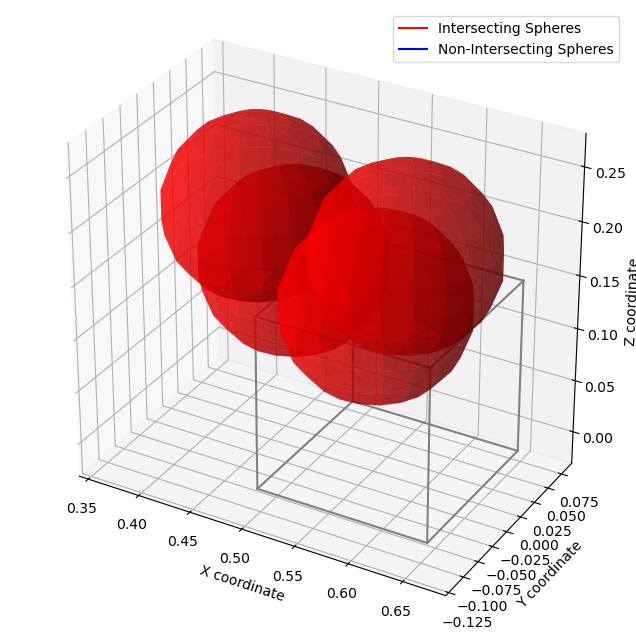

In [29]:
full_arm_mid_files = [
    "measurement_mid_fullarm/contact_points_log1_mid.csv",
    "measurement_mid_fullarm/contact_points_log2_mid.csv",
    "measurement_mid_fullarm/contact_points_log3_mid.csv"
]
for selected_csv_file in full_arm_mid_files:
    analysis(selected_csv_file)

#BOX LEFT PLACEMENT

In [30]:
box_center = [0.565, 0.11, 0.0825-0.025]
box_dimensions = [0.16, 0.16, 0.165]
fixed_sphere_diameter = 0.16

### EEF LEFT

Processing file: measurement_left_EEF/contact_points_log1_left.csv
Box Center: [0.565, 0.11, 0.0575], Dimensions: [0.16, 0.16, 0.165]
Box Min: [0.48499999999999993, 0.03, -0.025], Box Max: [0.6449999999999999, 0.19, 0.14]
Sphere Diameter: 0.16, Radius: 0.08

Finished processing. Found 10 intersecting sphere(s) out of 10 total spheres.

Intersection Results for 'measurement_left_EEF/contact_points_log1_left.csv':
  Point 1 at [0.463, 0.082, 0.158]: Intersects = True
  Point 2 at [0.457, 0.072, 0.152]: Intersects = True
  Point 3 at [0.512, 0.146, 0.157]: Intersects = True
  Point 4 at [0.512, 0.167, 0.208]: Intersects = True
  Point 5 at [0.562, 0.093, 0.158]: Intersects = True
  Point 6 at [0.555, 0.076, 0.148]: Intersects = True
  Point 7 at [0.611, 0.152, 0.155]: Intersects = True
  Point 8 at [0.606, 0.173, 0.164]: Intersects = True
  Point 9 at [0.654, 0.091, 0.097]: Intersects = True
  Point 10 at [0.659, 0.066, 0.183]: Intersects = True


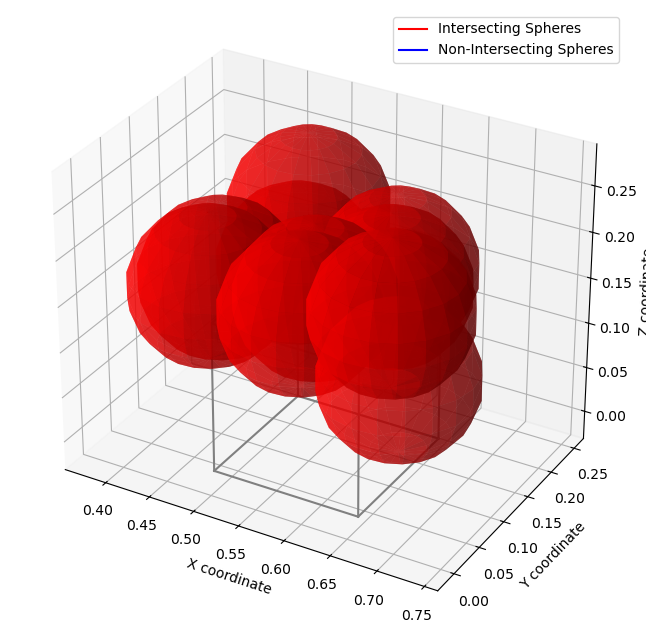

Processing file: measurement_left_EEF/contact_points_log2_left.csv
Box Center: [0.565, 0.11, 0.0575], Dimensions: [0.16, 0.16, 0.165]
Box Min: [0.48499999999999993, 0.03, -0.025], Box Max: [0.6449999999999999, 0.19, 0.14]
Sphere Diameter: 0.16, Radius: 0.08

Finished processing. Found 10 intersecting sphere(s) out of 10 total spheres.

Intersection Results for 'measurement_left_EEF/contact_points_log2_left.csv':
  Point 1 at [0.463, 0.084, 0.158]: Intersects = True
  Point 2 at [0.457, 0.068, 0.147]: Intersects = True
  Point 3 at [0.512, 0.149, 0.157]: Intersects = True
  Point 4 at [0.512, 0.167, 0.207]: Intersects = True
  Point 5 at [0.563, 0.093, 0.158]: Intersects = True
  Point 6 at [0.564, 0.075, 0.21]: Intersects = True
  Point 7 at [0.608, 0.154, 0.13]: Intersects = True
  Point 8 at [0.606, 0.168, 0.158]: Intersects = True
  Point 9 at [0.661, 0.091, 0.152]: Intersects = True
  Point 10 at [0.66, 0.067, 0.194]: Intersects = True


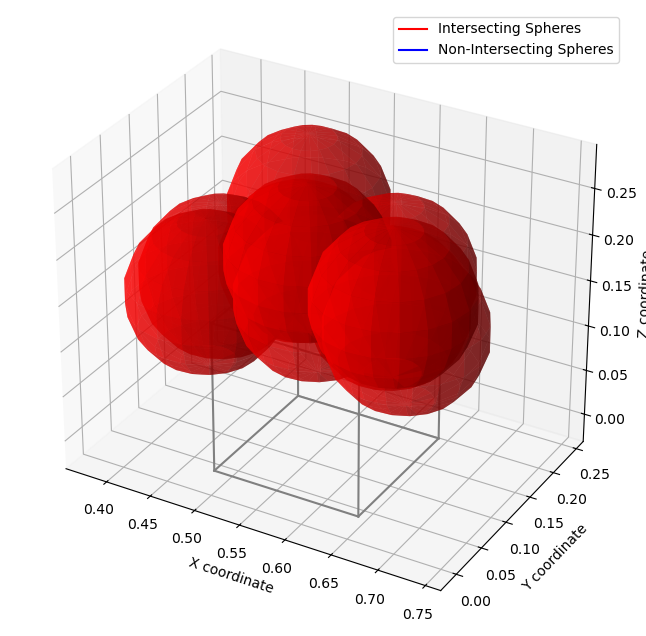

Processing file: measurement_left_EEF/contact_points_log3_left.csv
Box Center: [0.565, 0.11, 0.0575], Dimensions: [0.16, 0.16, 0.165]
Box Min: [0.48499999999999993, 0.03, -0.025], Box Max: [0.6449999999999999, 0.19, 0.14]
Sphere Diameter: 0.16, Radius: 0.08

Finished processing. Found 10 intersecting sphere(s) out of 10 total spheres.

Intersection Results for 'measurement_left_EEF/contact_points_log3_left.csv':
  Point 1 at [0.463, 0.086, 0.158]: Intersects = True
  Point 2 at [0.458, 0.073, 0.165]: Intersects = True
  Point 3 at [0.512, 0.147, 0.157]: Intersects = True
  Point 4 at [0.512, 0.172, 0.206]: Intersects = True
  Point 5 at [0.568, 0.095, 0.195]: Intersects = True
  Point 6 at [0.554, 0.085, 0.147]: Intersects = True
  Point 7 at [0.612, 0.157, 0.157]: Intersects = True
  Point 8 at [0.631, 0.187, 0.218]: Intersects = True
  Point 9 at [0.662, 0.093, 0.159]: Intersects = True
  Point 10 at [0.663, 0.066, 0.211]: Intersects = True


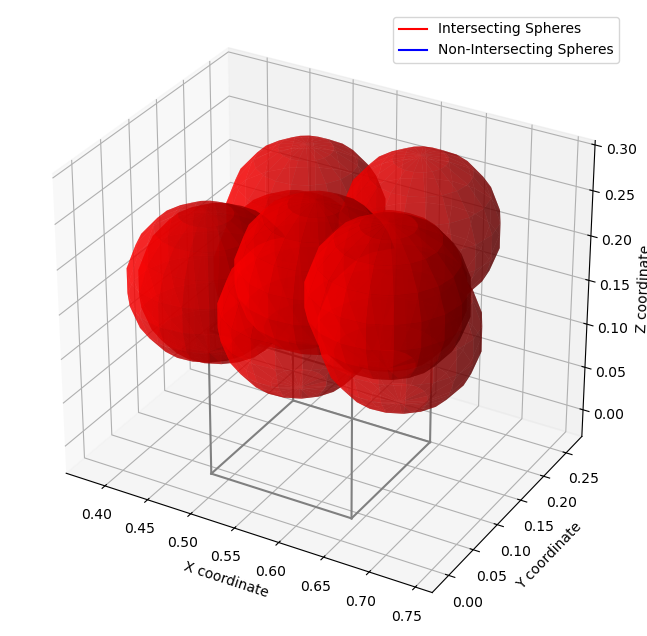

In [31]:
eef_left_files = [
    "measurement_left_EEF/contact_points_log1_left.csv",
    "measurement_left_EEF/contact_points_log2_left.csv",
    "measurement_left_EEF/contact_points_log3_left.csv"
]
for selected_csv_file in eef_left_files:
    analysis(selected_csv_file,box_center = box_center,box_dimensions = box_dimensions,fixed_sphere_diameter = fixed_sphere_diameter)

### FULL-ARM LEFT

Processing file: measurement_left_fullarm/contact_points_log1_left.csv
Box Center: [0.565, 0.11, 0.0575], Dimensions: [0.16, 0.16, 0.165]
Box Min: [0.48499999999999993, 0.03, -0.025], Box Max: [0.6449999999999999, 0.19, 0.14]
Sphere Diameter: 0.16, Radius: 0.08

Finished processing. Found 3 intersecting sphere(s) out of 4 total spheres.

Intersection Results for 'measurement_left_fullarm/contact_points_log1_left.csv':
  Point 1 at [0.477, 0.091, 0.153]: Intersects = True
  Point 2 at [0.442, 0.082, 0.193]: Intersects = True
  Point 3 at [0.419, 0.095, 0.153]: Intersects = True
  Point 4 at [0.399, 0.096, 0.193]: Intersects = False


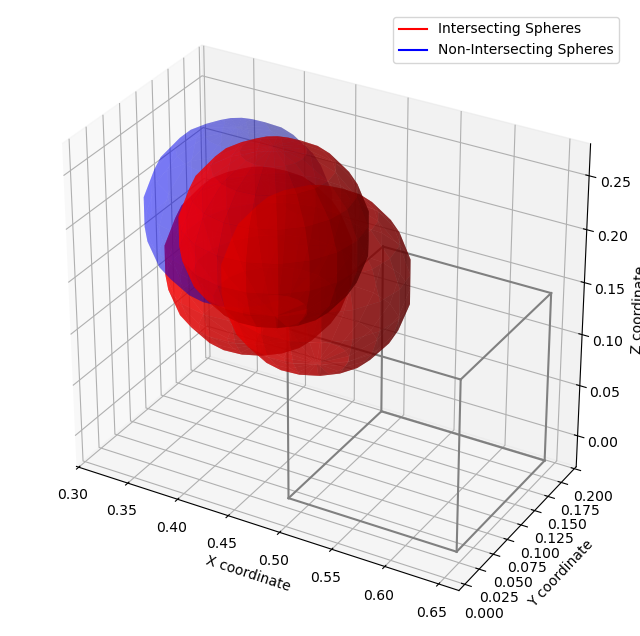

Processing file: measurement_left_fullarm/contact_points_log2_left.csv
Box Center: [0.565, 0.11, 0.0575], Dimensions: [0.16, 0.16, 0.165]
Box Min: [0.48499999999999993, 0.03, -0.025], Box Max: [0.6449999999999999, 0.19, 0.14]
Sphere Diameter: 0.16, Radius: 0.08

Finished processing. Found 4 intersecting sphere(s) out of 4 total spheres.

Intersection Results for 'measurement_left_fullarm/contact_points_log2_left.csv':
  Point 1 at [0.476, 0.085, 0.153]: Intersects = True
  Point 2 at [0.441, 0.065, 0.193]: Intersects = True
  Point 3 at [0.467, 0.096, 0.153]: Intersects = True
  Point 4 at [0.579, 0.075, 0.195]: Intersects = True


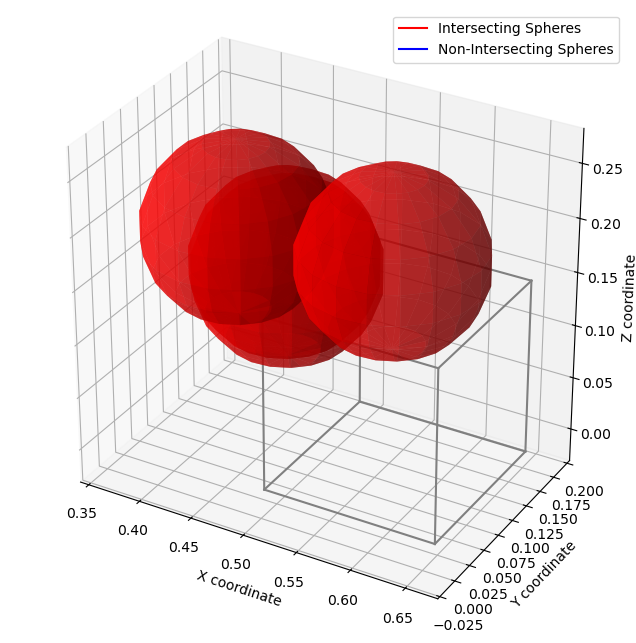

In [32]:
fullarm_left_files = [
    "measurement_left_fullarm/contact_points_log1_left.csv",
    "measurement_left_fullarm/contact_points_log2_left.csv",
]
for selected_csv_file in fullarm_left_files:
    analysis(selected_csv_file,box_center = box_center,box_dimensions = box_dimensions,fixed_sphere_diameter = fixed_sphere_diameter)

# BOX PLACEMENT RIGHT

In [33]:
box_center = [0.565, -0.11, 0.0825-0.025]
box_dimensions = [0.16, 0.16, 0.165]
fixed_sphere_diameter = 0.16

### EEF RIGHT

Processing file: measurement_right_EEF/contact_points_log1_right.csv
Box Center: [0.565, -0.11, 0.0575], Dimensions: [0.16, 0.16, 0.165]
Box Min: [0.48499999999999993, -0.19, -0.025], Box Max: [0.6449999999999999, -0.03, 0.14]
Sphere Diameter: 0.16, Radius: 0.08

Finished processing. Found 10 intersecting sphere(s) out of 10 total spheres.

Intersection Results for 'measurement_right_EEF/contact_points_log1_right.csv':
  Point 1 at [0.461, -0.134, 0.157]: Intersects = True
  Point 2 at [0.457, -0.153, 0.174]: Intersects = True
  Point 3 at [0.512, -0.065, 0.158]: Intersects = True
  Point 4 at [0.51, -0.04, 0.188]: Intersects = True
  Point 5 at [0.562, -0.117, 0.157]: Intersects = True
  Point 6 at [0.555, -0.133, 0.146]: Intersects = True
  Point 7 at [0.612, -0.059, 0.158]: Intersects = True
  Point 8 at [0.614, -0.036, 0.21]: Intersects = True
  Point 9 at [0.662, -0.12, 0.154]: Intersects = True
  Point 10 at [0.657, -0.14, 0.163]: Intersects = True


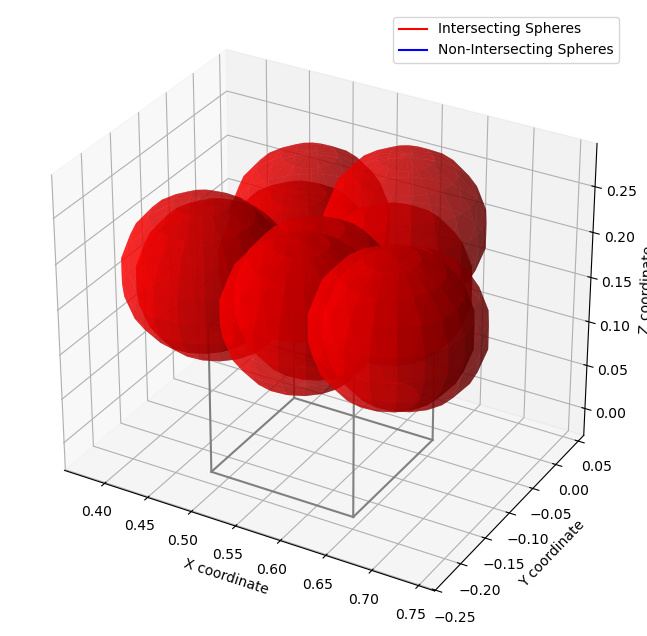

Processing file: measurement_right_EEF/contact_points_log2_right.csv
Box Center: [0.565, -0.11, 0.0575], Dimensions: [0.16, 0.16, 0.165]
Box Min: [0.48499999999999993, -0.19, -0.025], Box Max: [0.6449999999999999, -0.03, 0.14]
Sphere Diameter: 0.16, Radius: 0.08

Finished processing. Found 10 intersecting sphere(s) out of 10 total spheres.

Intersection Results for 'measurement_right_EEF/contact_points_log2_right.csv':
  Point 1 at [0.461, -0.136, 0.157]: Intersects = True
  Point 2 at [0.461, -0.151, 0.207]: Intersects = True
  Point 3 at [0.512, -0.063, 0.157]: Intersects = True
  Point 4 at [0.512, -0.038, 0.193]: Intersects = True
  Point 5 at [0.562, -0.115, 0.157]: Intersects = True
  Point 6 at [0.563, -0.134, 0.208]: Intersects = True
  Point 7 at [0.612, -0.06, 0.158]: Intersects = True
  Point 8 at [0.615, -0.034, 0.21]: Intersects = True
  Point 9 at [0.662, -0.116, 0.157]: Intersects = True
  Point 10 at [0.654, -0.136, 0.147]: Intersects = True


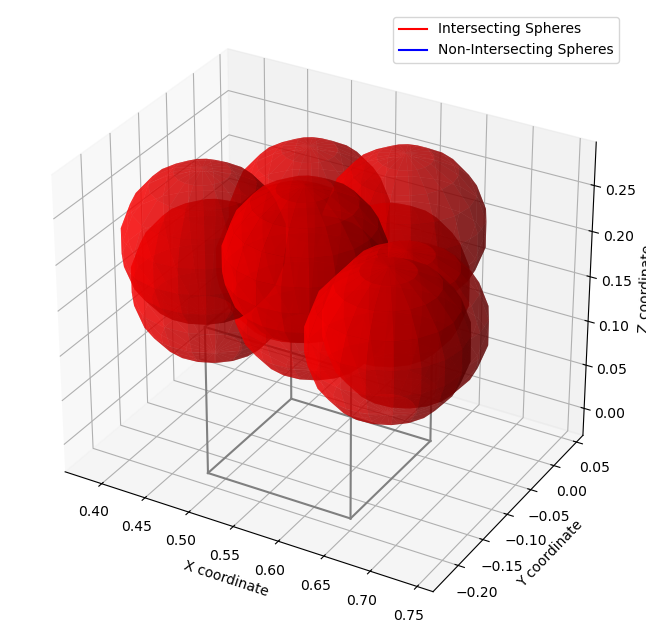

Processing file: measurement_right_EEF/contact_points_log3_right.csv
Box Center: [0.565, -0.11, 0.0575], Dimensions: [0.16, 0.16, 0.165]
Box Min: [0.48499999999999993, -0.19, -0.025], Box Max: [0.6449999999999999, -0.03, 0.14]
Sphere Diameter: 0.16, Radius: 0.08

Finished processing. Found 10 intersecting sphere(s) out of 10 total spheres.

Intersection Results for 'measurement_right_EEF/contact_points_log3_right.csv':
  Point 1 at [0.462, -0.132, 0.157]: Intersects = True
  Point 2 at [0.461, -0.148, 0.207]: Intersects = True
  Point 3 at [0.512, -0.066, 0.158]: Intersects = True
  Point 4 at [0.509, -0.039, 0.177]: Intersects = True
  Point 5 at [0.56, -0.116, 0.146]: Intersects = True
  Point 6 at [0.562, -0.136, 0.2]: Intersects = True
  Point 7 at [0.612, -0.056, 0.152]: Intersects = True
  Point 8 at [0.605, -0.033, 0.148]: Intersects = True
  Point 9 at [0.661, -0.119, 0.15]: Intersects = True
  Point 10 at [0.656, -0.139, 0.158]: Intersects = True


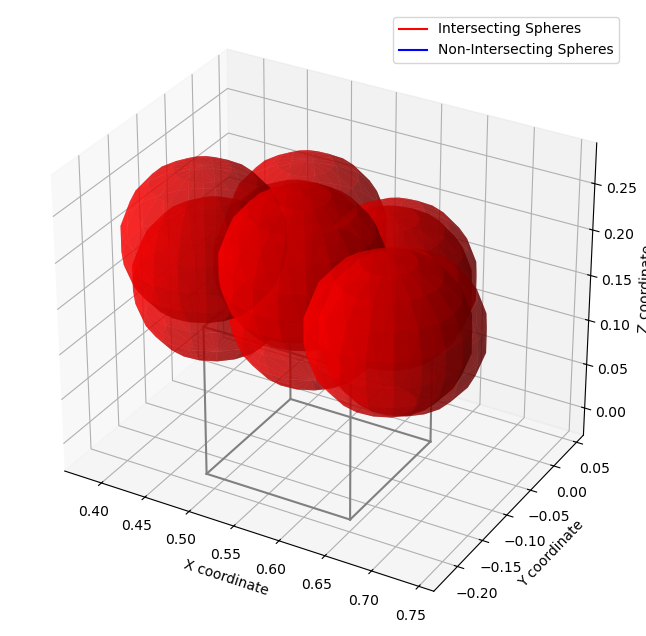

In [34]:
eef_right_files = [
    "measurement_right_EEF/contact_points_log1_right.csv",
    "measurement_right_EEF/contact_points_log2_right.csv",
    "measurement_right_EEF/contact_points_log3_right.csv"
]
for selected_csv_file in eef_right_files:
    analysis(selected_csv_file,box_center = box_center,box_dimensions = box_dimensions,fixed_sphere_diameter = fixed_sphere_diameter)

### FULL-ARM RIGHT

Processing file: measurement_right_fullarm/contact_points_log1_right.csv
Box Center: [0.565, -0.11, 0.0575], Dimensions: [0.16, 0.16, 0.165]
Box Min: [0.48499999999999993, -0.19, -0.025], Box Max: [0.6449999999999999, -0.03, 0.14]
Sphere Diameter: 0.16, Radius: 0.08

Finished processing. Found 4 intersecting sphere(s) out of 4 total spheres.

Intersection Results for 'measurement_right_fullarm/contact_points_log1_right.csv':
  Point 1 at [0.461, -0.098, 0.153]: Intersects = True
  Point 2 at [0.427, -0.06, 0.192]: Intersects = True
  Point 3 at [0.562, -0.131, 0.153]: Intersects = True
  Point 4 at [0.573, -0.135, 0.194]: Intersects = True


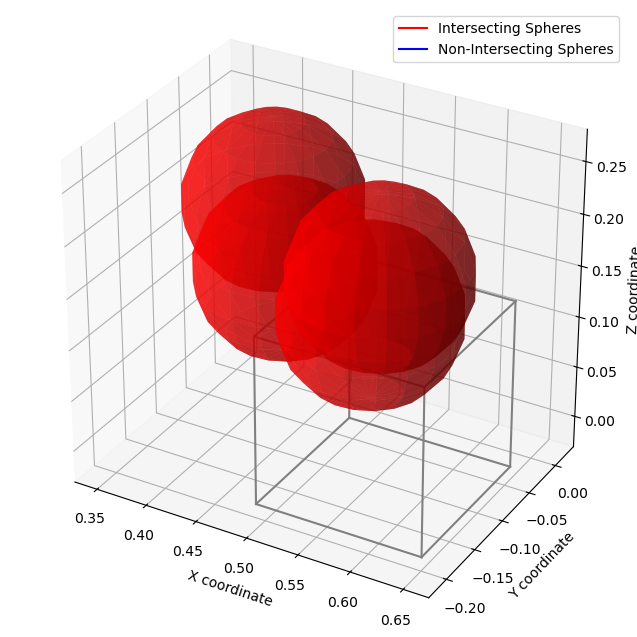

Processing file: measurement_right_fullarm/contact_points_log2_right.csv
Box Center: [0.565, -0.11, 0.0575], Dimensions: [0.16, 0.16, 0.165]
Box Min: [0.48499999999999993, -0.19, -0.025], Box Max: [0.6449999999999999, -0.03, 0.14]
Sphere Diameter: 0.16, Radius: 0.08

Finished processing. Found 4 intersecting sphere(s) out of 4 total spheres.

Intersection Results for 'measurement_right_fullarm/contact_points_log2_right.csv':
  Point 1 at [0.455, -0.104, 0.153]: Intersects = True
  Point 2 at [0.446, -0.074, 0.192]: Intersects = True
  Point 3 at [0.499, -0.084, 0.152]: Intersects = True
  Point 4 at [0.575, -0.124, 0.196]: Intersects = True


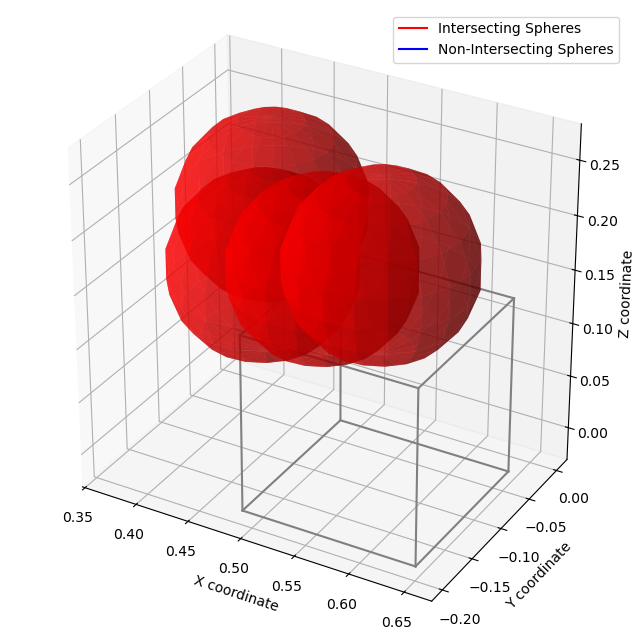

Processing file: measurement_right_fullarm/contact_points_log3_right.csv
Box Center: [0.565, -0.11, 0.0575], Dimensions: [0.16, 0.16, 0.165]
Box Min: [0.48499999999999993, -0.19, -0.025], Box Max: [0.6449999999999999, -0.03, 0.14]
Sphere Diameter: 0.16, Radius: 0.08

Finished processing. Found 4 intersecting sphere(s) out of 4 total spheres.

Intersection Results for 'measurement_right_fullarm/contact_points_log3_right.csv':
  Point 1 at [0.462, -0.102, 0.153]: Intersects = True
  Point 2 at [0.44, -0.086, 0.192]: Intersects = True
  Point 3 at [0.565, -0.125, 0.153]: Intersects = True
  Point 4 at [0.579, -0.12, 0.194]: Intersects = True


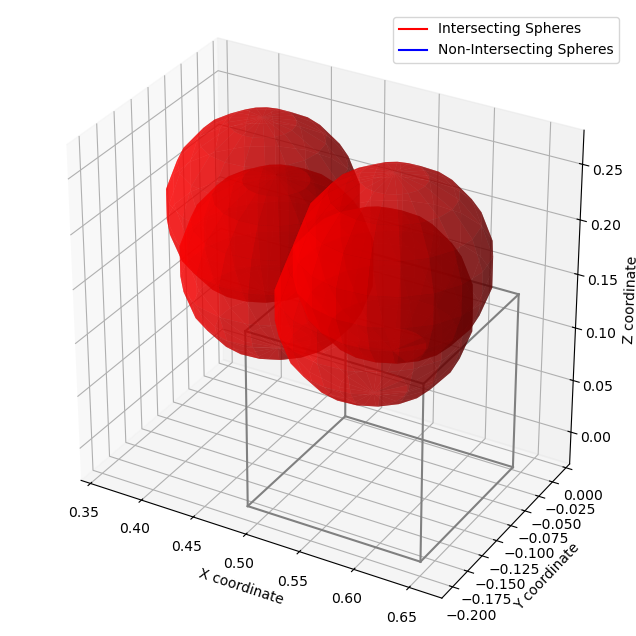

In [35]:
fullarm_right_files = [
    "measurement_right_fullarm/contact_points_log1_right.csv",
    "measurement_right_fullarm/contact_points_log2_right.csv",
    "measurement_right_fullarm/contact_points_log3_right.csv"
]
for selected_csv_file in fullarm_right_files:
    analysis(selected_csv_file,box_center = box_center,box_dimensions = box_dimensions,fixed_sphere_diameter = fixed_sphere_diameter)